In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filenaprme in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv
/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable

%matplotlib inline

sns.set_theme(style="whitegrid", palette="muted", context="talk", font_scale=1.2)

plt.rcParams.update({
    'figure.figsize': (10, 6),
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12
})

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## EDA

from prettytable import PrettyTable

def print_missing_table(train_copy, test_copy, target):
    table = PrettyTable()
    table.field_names = ['Feature', 'Data Type', 'Train Missing %', 'Test Missing %']

    for column in train_copy.columns:
        data_type = str(train_copy[column].dtype)
        non_null_count_train = np.round(100 - train_copy[column].count() / train_copy.shape[0] * 100, 1)
        non_null_count_test = np.round(100 - test_copy[column].count() / test_copy.shape[0] * 100, 1) if column != target else "NA"
        table.add_row([column, data_type, non_null_count_train, non_null_count_test])
    
    print(table)


def plot_categorical(data, column_name):
    f, ax = plt.subplots(1, 2, figsize=(18, 8))
    data[column_name].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
    ax[0].set_title(column_name)
    ax[0].set_ylabel('')
    sns.countplot(x=column_name, data=data, ax=ax[1])
    ax[1].set_title(column_name)
    plt.show()
    
def plot_correlation_heatmap(data, numerical_cols, target_col):
    df = data=data[numerical_cols + [target_col]]
    corr = df.corr()
    mask = np.triu(corr)
    plt.figure(figsize=(15, 11))
    sns.heatmap(corr, mask=mask, annot=True, fmt=".4f")
    plt.show()
    
    
def plot_pairplot(data, numerical_cols, target_col):
    pairplot = sns.pairplot(data=data[numerical_cols + [target_col]], 
                            hue=target_col, 
                            corner=True, 
                            plot_kws={'alpha': 0.7, 's': 50, 'edgecolor': 'k'},
                            palette='Set1', 
                            diag_kws={'edgecolor':'k'})
    pairplot.fig.suptitle("Pairplot of Numerical Variables", y=1.02)
    plt.show()
    
def plot_violin_plots(data, numerical_cols, target):
    n_rows = len(numerical_cols)
    fig, axs = plt.subplots(n_rows, 1, figsize=(12, 4 * n_rows))

    for i, col in enumerate(numerical_cols):
        sns.violinplot(x=target, y=col, data=data, ax=axs[i])
        axs[i].set_title(f'{col.title()} Distribution by Target (Train)', fontsize=14)
        axs[i].set_xlabel(target.title(), fontsize=12)
        axs[i].set_ylabel(col.title(), fontsize=12)
        sns.despine()

    fig.tight_layout()
    plt.show()
    
def plot_histograms(data, continuous_vars, target_col):
    for column in continuous_vars:
        if data[column].dtype == 'float16':
            data[column] = data[column].astype('float32')

        fig, ax = plt.subplots(figsize=(18, 4))
        sns.histplot(data=data, x=column, hue=target_col, bins=50, kde=True)
        plt.show()

def plot_countplot(data, column_name):
    sns.countplot(x=column_name, data=data)
    plt.title(f'Count Plot of {column_name}')
    plt.show()

## Read data

In [ ]:
train = pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv")
original = pd.read_csv("/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv")
sample = pd.read_csv("/kaggle/input/playground-series-s4e1/sample_submission.csv")


train.drop(columns=["id"], inplace=True)
test.drop(columns=["id"], inplace=True)
original.drop(columns=["RowNumber"], inplace=True)

train = pd.concat([train, original.dropna()], axis=0)
train.reset_index(inplace=True, drop=True)

target_col = "Exited"

In [ ]:
train.shape

(175032, 13)

In [ ]:
train.duplicated().sum()

2

In [ ]:
train = train.drop_duplicates()

In [ ]:
print_missing_table(train, test, target_col)

+-----------------+-----------+-----------------+----------------+
|     Feature     | Data Type | Train Missing % | Test Missing % |
+-----------------+-----------+-----------------+----------------+
|    CustomerId   |   int64   |       0.0       |      0.0       |
|     Surname     |   object  |       0.0       |      0.0       |
|   CreditScore   |   int64   |       0.0       |      0.0       |
|    Geography    |   object  |       0.0       |      0.0       |
|      Gender     |   object  |       0.0       |      0.0       |
|       Age       |  float64  |       0.0       |      0.0       |
|      Tenure     |   int64   |       0.0       |      0.0       |
|     Balance     |  float64  |       0.0       |      0.0       |
|  NumOfProducts  |   int64   |       0.0       |      0.0       |
|    HasCrCard    |  float64  |       0.0       |      0.0       |
|  IsActiveMember |  float64  |       0.0       |      0.0       |
| EstimatedSalary |  float64  |       0.0       |      0.0    

In [ ]:
train = reduce_mem_usage(train)

Mem. usage decreased to  9.18 Mb (50.9% reduction)


In [ ]:
test = reduce_mem_usage(test)

Mem. usage decreased to  4.83 Mb (52.1% reduction)


In [ ]:
train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.000000,2,1.0,0.0,181449.968750,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.000000,2,1.0,1.0,49503.500000,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.000000,2,1.0,0.0,184866.687500,0
3,15741417,Kao,581,France,Male,34.0,2,148882.546875,1,1.0,1.0,84560.882812,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.000000,2,1.0,1.0,15068.830078,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175030 entries, 0 to 175030
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       175030 non-null  int32  
 1   Surname          175030 non-null  object 
 2   CreditScore      175030 non-null  int16  
 3   Geography        175030 non-null  object 
 4   Gender           175030 non-null  object 
 5   Age              175030 non-null  float16
 6   Tenure           175030 non-null  int8   
 7   Balance          175030 non-null  float32
 8   NumOfProducts    175030 non-null  int8   
 9   HasCrCard        175030 non-null  float16
 10  IsActiveMember   175030 non-null  float16
 11  EstimatedSalary  175030 non-null  float32
 12  Exited           175030 non-null  int8   
dtypes: float16(3), float32(2), int16(1), int32(1), int8(3), object(3)
memory usage: 9.2+ MB


## EDA

In [ ]:
# Unique value counts for each column
unique_counts = train.nunique()

# Threshold to distinguish continuous and categorical
threshold = 12

# Select only numeric columns for continuous variables
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()

continuous_vars = unique_counts[(unique_counts > threshold) & unique_counts.index.isin(numeric_cols)].index.tolist()
categorical_vars = unique_counts[(unique_counts <= threshold) | ~unique_counts.index.isin(numeric_cols)].index.tolist()

target_col = 'Exited'
id_col = ['id', 'CustomerId']

if target_col in categorical_vars:
    categorical_vars.remove(target_col)

for col in id_col:
    if col in continuous_vars:
        continuous_vars.remove(col)

print(f"Categorical Variables: {categorical_vars}")
print(f"Continuous/Numerical Variables: {continuous_vars}")

Categorical Variables: ['Surname', 'Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
Continuous/Numerical Variables: ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']


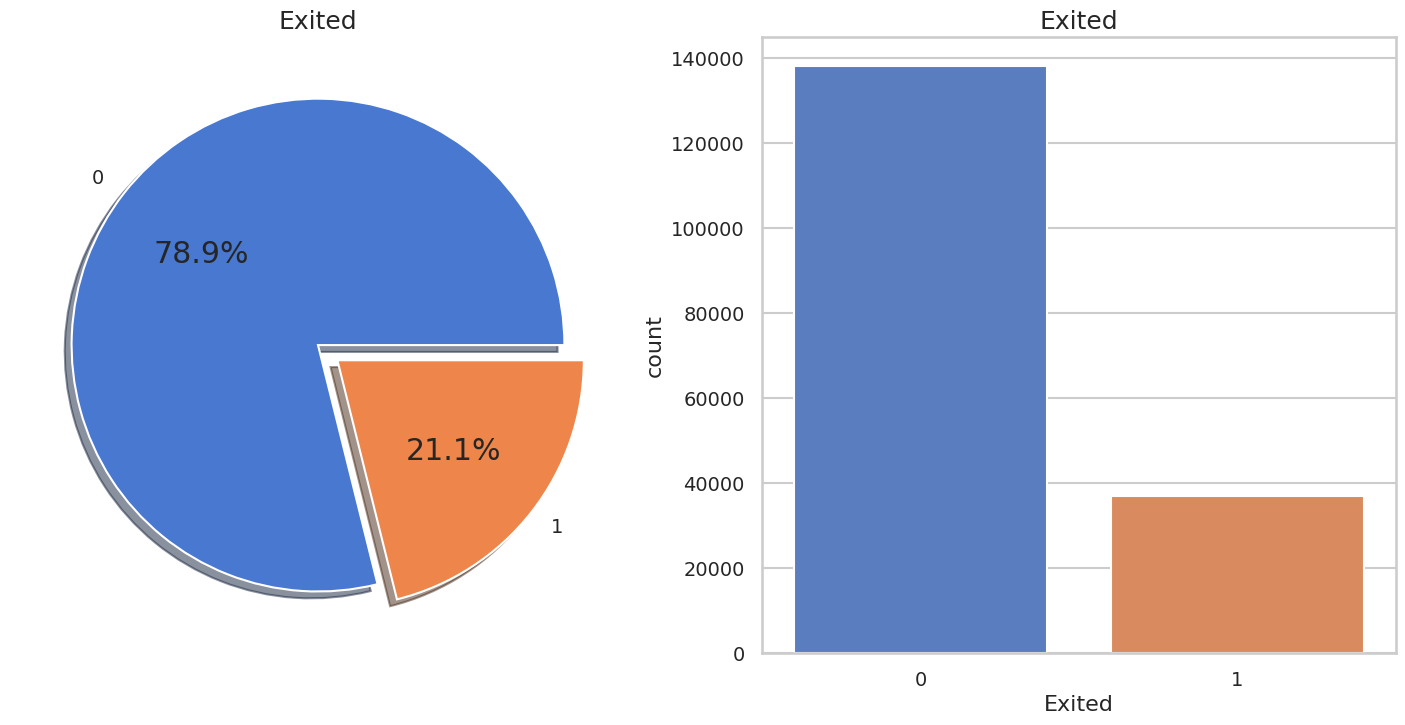

In [ ]:
plot_categorical(train, column_name='Exited')

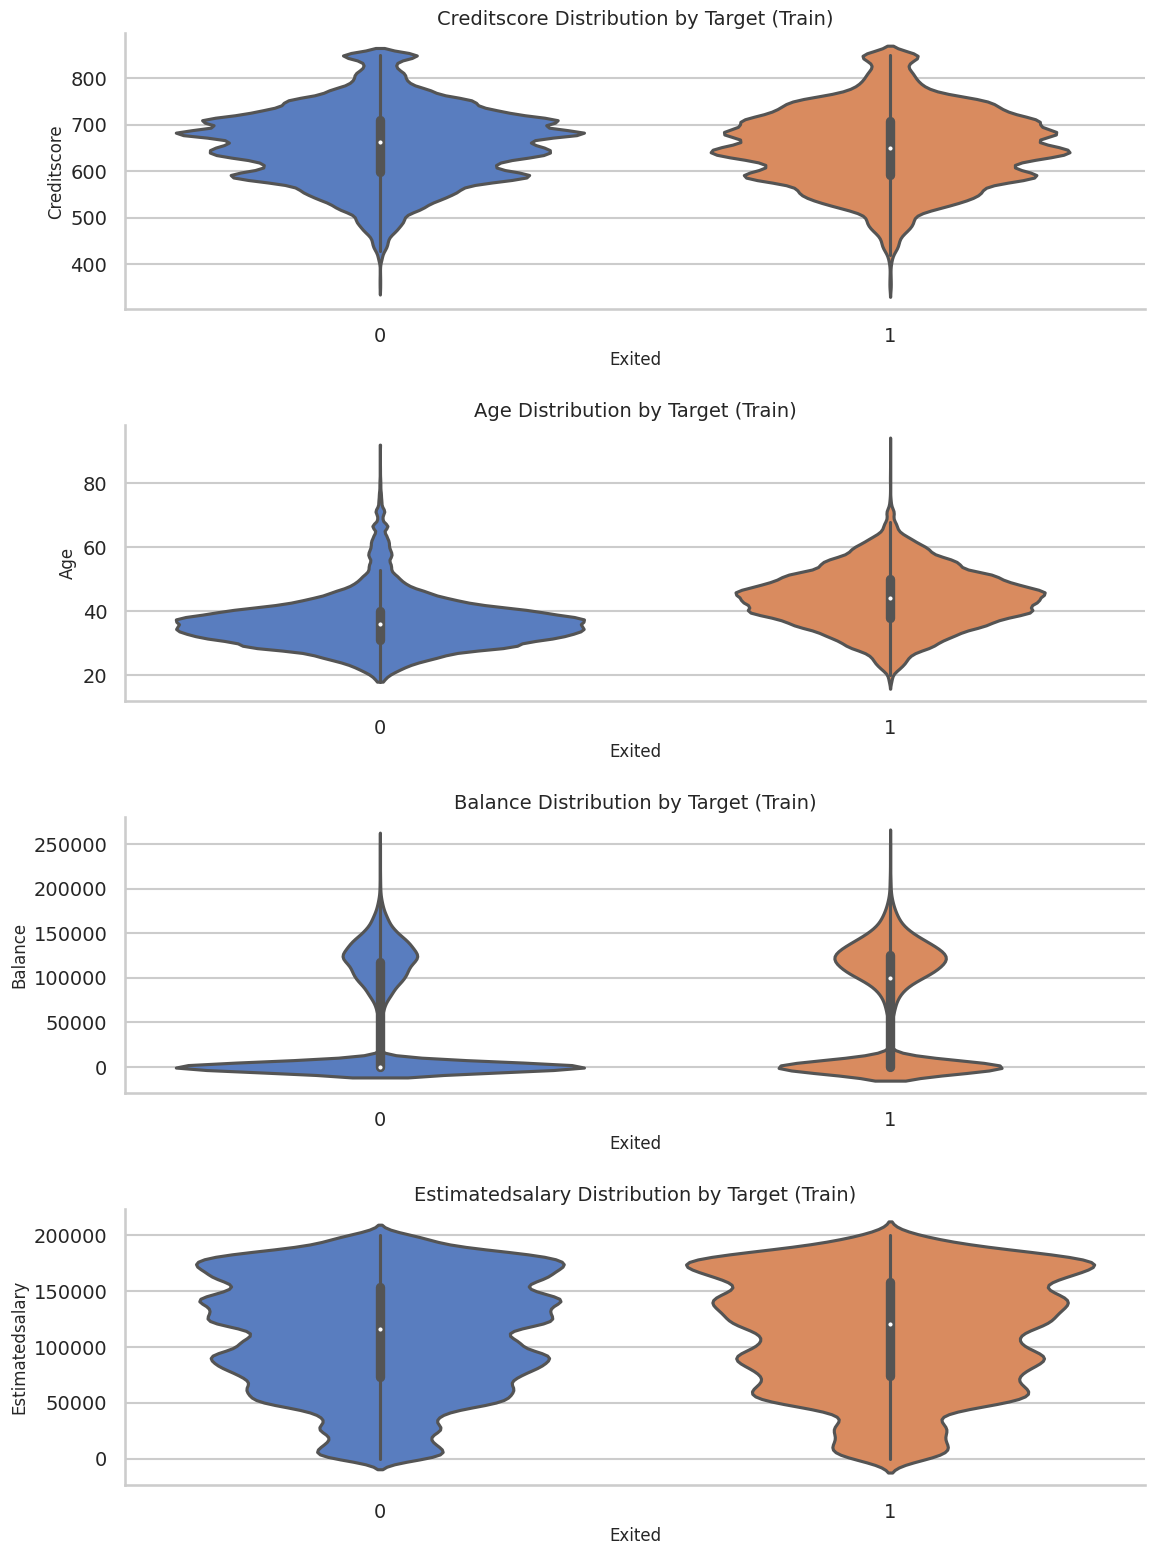

In [ ]:
plot_violin_plots(train, continuous_vars, target_col)

age seems to have a different distribution

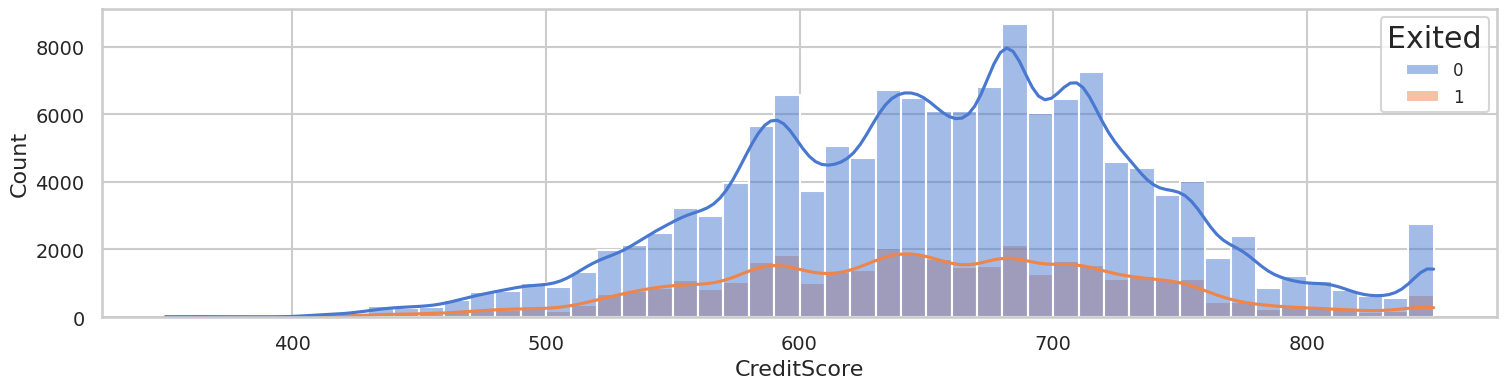

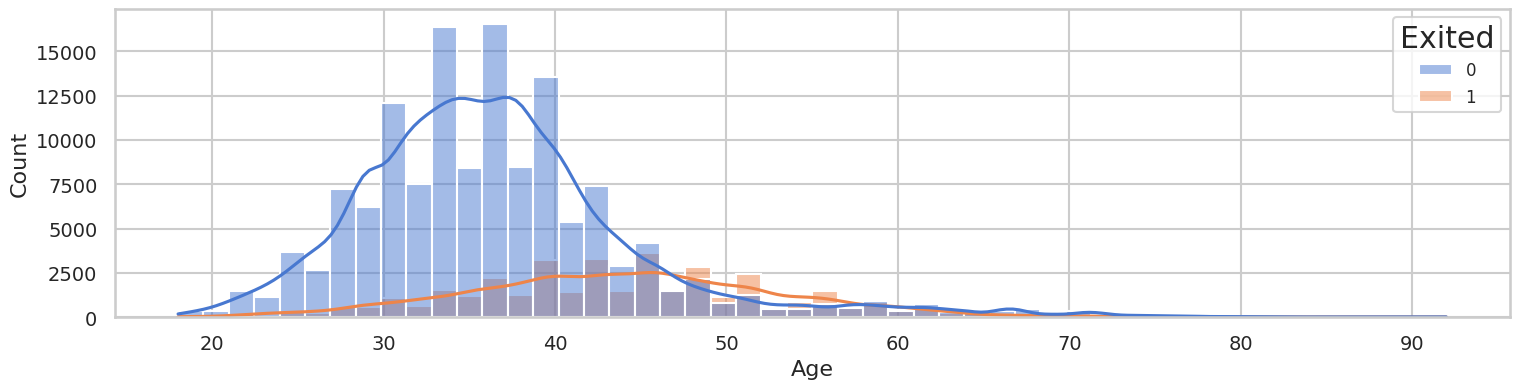

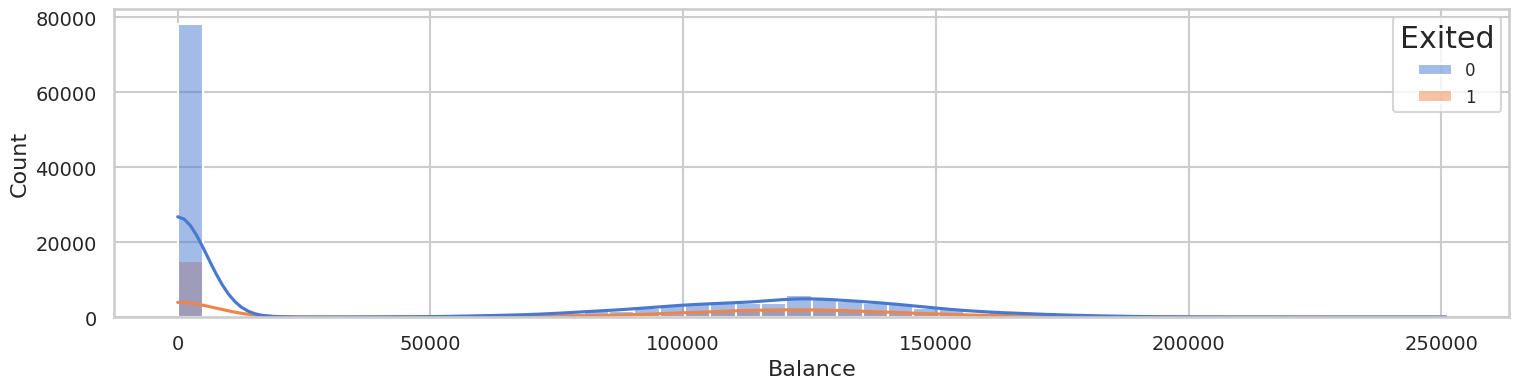

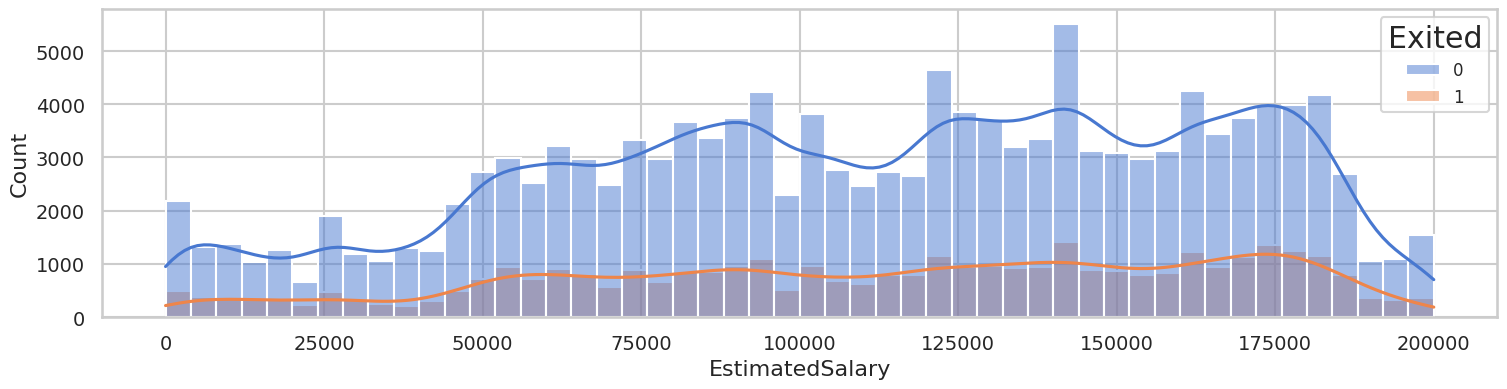

In [ ]:
plot_histograms(train, continuous_vars, target_col)

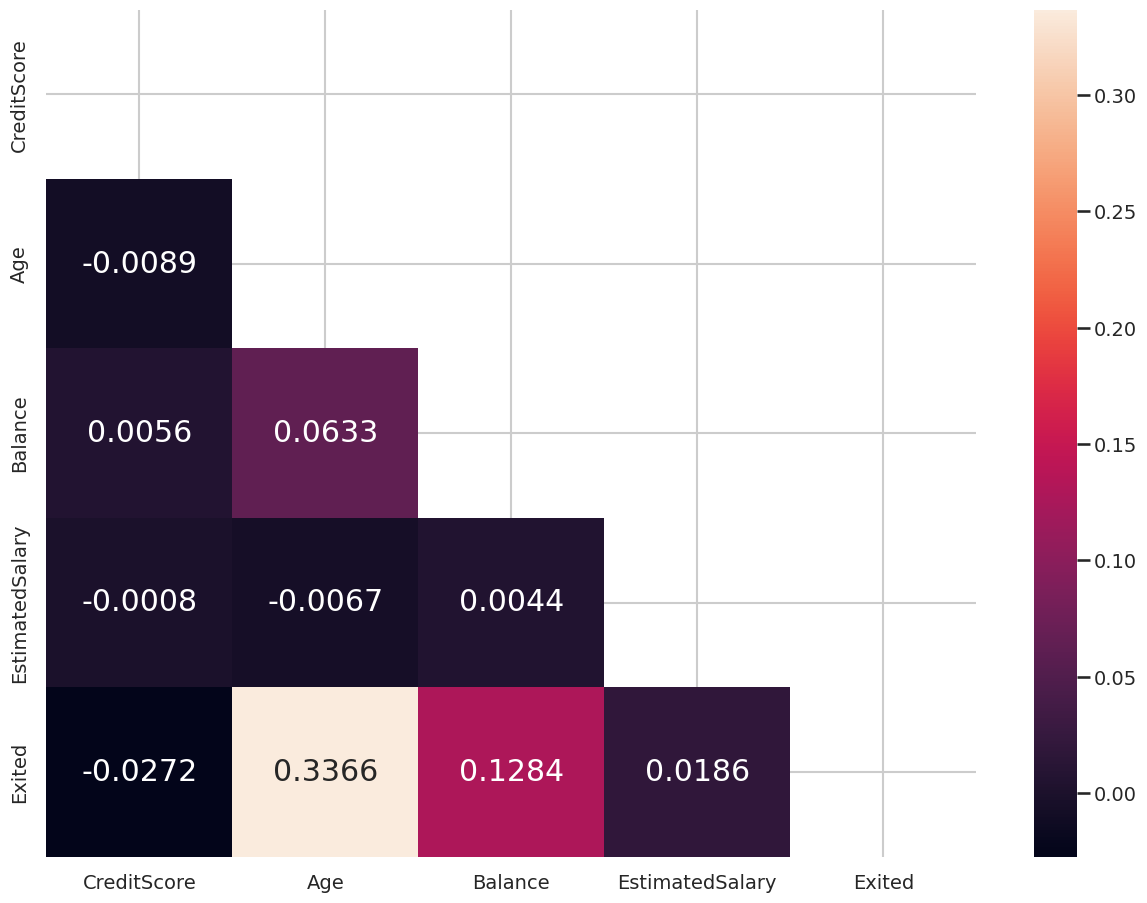

In [ ]:
plot_correlation_heatmap(train, continuous_vars, target_col)

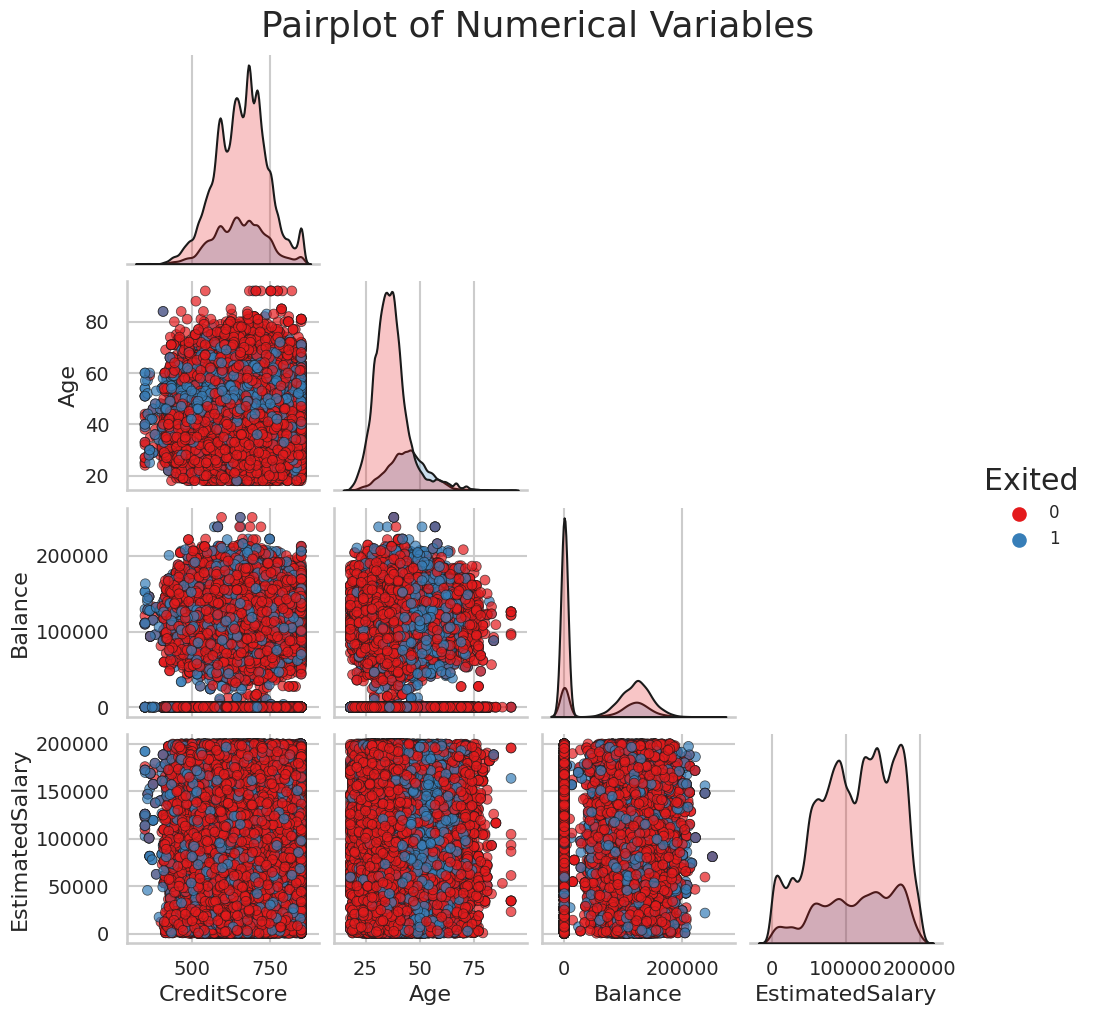

In [ ]:
plot_pairplot(train, continuous_vars, target_col)

## Feature engineering


source: 

- [🚀Churn Prediction: Ensemble w CB | XGB | LGBM | Kaggle](https://www.kaggle.com/code/yorkyong/churn-prediction-ensemble-w-cb-xgb-lgbm/notebook)
- [💰PS4E1 | Advanced Feature Engineering | Ensemble | Kaggle](https://www.kaggle.com/code/arunklenin/ps4e1-advanced-feature-engineering-ensemble#TFIDF-PCA-(Text-Transformation)
- [Playground S4E1|🏦Bank Churn💸 Prediction|Ensemble | Kaggle](https://www.kaggle.com/code/ashishkumarak/playground-s4e1-bank-churn-prediction-ensemble?scriptVersionId=157911965#%F0%9F%92%BD-Importing-the-data)

Pipeline resources

- [Understand and use a Pipeline | Kaggle](https://www.kaggle.com/code/lucabasa/understand-and-use-a-pipeline)
- [Pipelines for Preprocessing: A tutorial | Kaggle](https://www.kaggle.com/code/nnjjpp/pipelines-for-preprocessing-a-tutorial)

In [ ]:
train.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

### writing transformers



In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# surname

class TFIDFTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column, max_features, n_components):
        self.column = column
        self.max_features = max_features
        self.n_components = n_components
        self.vectorizer = TfidfVectorizer(max_features = max_features)
        self.svd = TruncatedSVD(n_components = n_components)
        
    def fit(self, X, y=None):
        vectors = self.vectorizer.fit_transform(X[self.column])
        self.svd.fit(vectors)
        return self
    
    def transform(self, X):
        vectors = self.vectorizer.transform(X[self.column])
        svd_result = self.svd.transform(vectors)
        
        tfidf_df = pd.DataFrame(svd_result, columns = [f"{self.column}_tfidf_{i}" for i in range(self.n_components)])
        X = pd.concat([X, tfidf_df], axis="columns")
        return X

# bin age, estimated salary and credit score

class VariableBinning(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins, column_name):
        self.n_bins = n_bins
        self.column_name = column_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.column_name not in X:
            raise ValueError(f"Column '{self.column_name}' not found in input data")
        transformed = pd.qcut(X[self.column_name], self.n_bins, labels=False, duplicates='drop')
        transformed[transformed.isna()] = 0
        transformed_series = pd.Series(transformed,
                                       name=f'QCut{self.n_bins}_{self.column_name}',
                                       index=X.index)
        X_copy = X.copy()
        return pd.concat([X_copy, transformed_series], axis=1)
    
    
# geography gender

class GeoGenderTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['Geo_Gender'] = X_copy['Geography'] + '_' + X_copy['Gender']
        return X_copy
    

# balance / salary

class BalanceSalaryRatioTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['Balance_Salary_Ratio'] = X_copy['Balance'] / X_copy['EstimatedSalary']
        return X_copy
    
# total products

class BalanceSalaryRatioTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['Total_Products_Used'] = X_copy['NumOfProducts'] + X_copy['HasCrCard']
        return X_copy
    
    
# gender and total product interaction

class TpGenderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, total_products_field='Total_Products_Used', gender_field='Gender'):
        self.total_products_field = total_products_field
        self.gender_field = gender_field
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['Tp_Gender'] = X_copy[self.total_products_field].astype('str') + X_copy[self.gender_field]
        return X_copy

    
class IsSeniorTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['IsSenior'] = X_copy['Age'].apply(lambda x: 1 if x >= 60 else 0)
        return X_copy


class QualityOfBalanceTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        quality_labels = [0, 1, 2, 3, 4]
        bins = [-1, 100, 1000, 10000, 50000, 1000000]
        quality_series = pd.cut(X_copy['Balance'], bins=bins, labels=quality_labels)
        X_copy['QualityOfBalance'] = quality_series
        return X_copy

class CreditScoreTierTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        score_labels = [0, 1, 2]
        bins = [0, 650, 750, 850]
        score_series = pd.cut(X_copy['CreditScore'], bins=bins, labels=score_labels)
        X_copy['CreditScoreTier'] = score_series
        return X_copy
    
class IsActiveByCreditCardTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['IsActive_by_CreditCard'] = X_copy['HasCrCard'] * X_copy['IsActiveMember']
        return X_copy
    

class ProductsPerTenureTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['Products_Per_Tenure'] = X_copy['Tenure'] / X_copy['NumOfProducts']
        return X_copy


class CustomerStatusTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['Customer_Status'] = X_copy['Tenure'].apply(lambda x: 0 if x < 2 else 1)
        return X_copy

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


class KMeansClusterer(BaseEstimator, TransformerMixin):
    def __init__(self, features, n_clusters=20, random_state=0, n_components=None):
        self.features = features
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.n_components = n_components
        self.kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=random_state)
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=n_components)
        
    def fit(self, X, y=None):
        X_scaled = self.scaler.fit_transform(X.loc[:, self.features])
        if self.n_components is not None:
            X_scaled = self.pca.fit_transform(X_scaled)
        self.kmeans.fit(X_scaled)
        
        return self
    
    def transform(self, X):
        X_scaled = self.scaler.transform(X.loc[:, self.features])
        
        # check for NaN and replace with zero
        if np.isnan(X_scaled).any():
            X_scaled = np.nan_to_num(X_scaled)
            
        if self.n_components is not None:
            X_scaled = self.pca.transform(X_scaled)
            
        X_new = pd.DataFrame()
        X_new["Cluster"] = self.kmeans.predict(X_scaled)
        
        X_copy = X.copy()
        
        # convert to dense format
        X_new["Cluster"] = X_new["Cluster"].values
        
        return pd.concat([X_copy.reset_index(drop=True), X_new.reset_index(drop=True)], axis=1)
    
clusterer_with_pca = KMeansClusterer(features=["CustomerId","EstimatedSalary","Balance"], n_clusters=10, random_state=123, n_components=3)
clusterer_with_pca.fit_transform(train)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Cluster
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.000000,2,1.0,0.0,181449.968750,0,4
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.000000,2,1.0,1.0,49503.500000,0,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.000000,2,1.0,0.0,184866.687500,0,4
3,15741417,Kao,581,France,Male,34.0,2,148882.546875,1,1.0,1.0,84560.882812,0,3
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.000000,2,1.0,1.0,15068.830078,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175025,15606229,Obijiaku,771,France,Male,39.0,5,0.000000,2,1.0,0.0,96270.640625,0,2
175026,15569892,Johnstone,516,France,Male,35.0,10,57369.609375,1,1.0,1.0,101699.773438,0,9
175027,15584532,Liu,709,France,Female,36.0,7,0.000000,1,0.0,1.0,42085.578125,1,2
175028,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.312500,2,1.0,0.0,92888.523438,1,5


In [ ]:
class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(self.cols, axis=1)

## making the pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


preprocessing_pipeline = Pipeline([
    ('kmeans', KMeansClusterer(features=["CustomerId", "EstimatedSalary", "Balance"], n_clusters=10, random_state=123, n_components=3)),
    ('surname_tfid', TFIDFTransformer(column="Surname", max_features=1000, n_components=5)),
    ('age_binning', VariableBinning(n_bins=5, column_name="Age")),
    ('salary_binning', VariableBinning(n_bins=10, column_name="EstimatedSalary")),
    ('balance_salary_ratio', BalanceSalaryRatioTransformer()),
    ('geo_gender', GeoGenderTransformer()),
    ('total_products', BalanceSalaryRatioTransformer()),  # Note: Should be TotalProductsTransformer, but not defined above
    ('tp_gender', TpGenderTransformer()),
    ('is_senior', IsSeniorTransformer()),
    ('quality_of_balance', QualityOfBalanceTransformer()),
    ('credit_score_tier', CreditScoreTierTransformer()),
    ('is_active_by_credit_card', IsActiveByCreditCardTransformer()),
    ('products_per_tenure', ProductsPerTenureTransformer()),
    ('customer_status', CustomerStatusTransformer()),
    ('drop', DropColumn(cols=['CustomerId', 'Surname'])),
    ('prep', ColumnTransformer([
        ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False), 
         ['Gender', 'Geography', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geo_Gender', 'Tp_Gender']),
        ],
        remainder='passthrough').set_output(transform='pandas')),
])

preprocessing_pipeline

Pipeline(steps=[('kmeans',
                 KMeansClusterer(features=['CustomerId', 'EstimatedSalary',
                                           'Balance'],
                                 n_clusters=10, n_components=3,
                                 random_state=123)),
                ('surname_tfid',
                 TFIDFTransformer(column='Surname', max_features=1000,
                                  n_components=5)),
                ('age_binning', VariableBinning(column_name='Age', n_bins=5)),
                ('salary_binning',
                 VariableBinning(column_name='EstimatedSalary'...
                ('products_per_tenure', ProductsPerTenureTransformer()),
                ('customer_status', CustomerStatusTransformer()),
                ('drop', DropColumn(cols=['CustomerId', 'Surname'])),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encode',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'Geography',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'Geo_Gender',
                                                   'Tp_Gender'])]))])

In [ ]:
df_train = preprocessing_pipeline.fit_transform(train.drop(['Exited'], axis=1))
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175030 entries, 0 to 175029
Data columns (total 49 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   encode__Gender_Female              175030 non-null  float64 
 1   encode__Gender_Male                175030 non-null  float64 
 2   encode__Geography_France           175030 non-null  float64 
 3   encode__Geography_Germany          175030 non-null  float64 
 4   encode__Geography_Spain            175030 non-null  float64 
 5   encode__NumOfProducts_1            175030 non-null  float64 
 6   encode__NumOfProducts_2            175030 non-null  float64 
 7   encode__NumOfProducts_3            175030 non-null  float64 
 8   encode__NumOfProducts_4            175030 non-null  float64 
 9   encode__HasCrCard_0.0              175030 non-null  float64 
 10  encode__HasCrCard_1.0              175030 non-null  float64 
 11  encode__IsActiveMember_0.0

In [ ]:
df_test = pd.DataFrame(preprocessing_pipeline.transform(test))
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 49 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   encode__Gender_Female              110023 non-null  float64 
 1   encode__Gender_Male                110023 non-null  float64 
 2   encode__Geography_France           110023 non-null  float64 
 3   encode__Geography_Germany          110023 non-null  float64 
 4   encode__Geography_Spain            110023 non-null  float64 
 5   encode__NumOfProducts_1            110023 non-null  float64 
 6   encode__NumOfProducts_2            110023 non-null  float64 
 7   encode__NumOfProducts_3            110023 non-null  float64 
 8   encode__NumOfProducts_4            110023 non-null  float64 
 9   encode__HasCrCard_0.0              110023 non-null  float64 
 10  encode__HasCrCard_1.0              110023 non-null  float64 
 11  encode__IsActiveMember_0.0

In [ ]:
from sklearn.preprocessing import RobustScaler

class RobustScalerNamed(RobustScaler, TransformerMixin):
    def get_feature_names_out(self, X, y=None):
        return X.columns.tolist()

    def transform(self, X, y=None):
        transformed = super().transform(X, y)
        return pd.DataFrame(transformed, columns=X.columns)
    
modelling_pipeline = Pipeline(preprocessing_pipeline.steps + [('scale',RobustScaler().set_output(transform='pandas')),])
modelling_pipeline

Pipeline(steps=[('kmeans',
                 KMeansClusterer(features=['CustomerId', 'EstimatedSalary',
                                           'Balance'],
                                 n_clusters=10, n_components=3,
                                 random_state=123)),
                ('surname_tfid',
                 TFIDFTransformer(column='Surname', max_features=1000,
                                  n_components=5)),
                ('age_binning', VariableBinning(column_name='Age', n_bins=5)),
                ('salary_binning',
                 VariableBinning(column_name='EstimatedSalary'...
                ('customer_status', CustomerStatusTransformer()),
                ('drop', DropColumn(cols=['CustomerId', 'Surname'])),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encode',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'Geography',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'Geo_Gender',
                                                   'Tp_Gender'])])),
                ('scale', RobustScaler())])

## Modeling

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix
from sklearn.metrics import precision_score, f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

import optuna

In [ ]:
X = train.drop(['Exited'], axis=1)
y = train['Exited']

### XGBoost

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
# Assuming 'skf' is your StratifiedKFold object
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

def objective_xgb(trial):
    """Define the objective function for XGBClassifier"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 150, 1000),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'random_state': trial.suggest_categorical('random_state', [42]),
        'tree_method': 'hist',  
        'device' : 'cuda', # Use GPU for training
        'eval_metric': 'auc',  # Evaluation metric
        'verbosity': 2,  # Set verbosity to 0 for less output
    }

    xgb_model = xgb.XGBClassifier(**params)
    xgb_pipeline = make_pipeline(modelling_pipeline, xgb_model)

    cv = abs(cross_val_score(xgb_pipeline, X, y, cv=skf, scoring='roc_auc').mean())

    return cv



study = optuna.create_study(direction='maximize')
study.optimize(objective_xgb, n_trials=10)

# Get the best parameters
best_params_xgb = study.best_params
print("Best Hyperparameters for XGBoost:", best_params_xgb)

In [ ]:
best_params_xgb = {'max_depth': 6, 'min_child_weight': 4, 'learning_rate': 0.06967111655021381, 'n_estimators': 971, 'subsample': 0.6490608007381499, 'colsample_bytree': 0.3129267516560412, 'random_state': 42}

In [ ]:
xgb_model_optimized = xgb.XGBClassifier(**best_params_xgb)
xgb_pipeline_optimized = make_pipeline(modelling_pipeline, xgb_model_optimized)

In [ ]:
# # number of folds
# n_splits = 10

# # StratifiedKFold
# stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# # cross-validation results
# cv_results = []

# # stratified k-fold cross-validation
# for fold, (train_idx, val_idx) in enumerate(stratkf.split(X, y)):
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#     xgb_pipeline_optimized.fit(X_train, y_train)

#     # predictions on the validation set
#     y_val_pred_prob = xgb_pipeline_optimized.predict_proba(X_val)[:, 1]
#     y_pred = xgb_pipeline_optimized.predict(X_val)
        
#     f1 = f1_score(y_val, y_pred, average='weighted')

#     # Evaluating the model
#     roc_auc = roc_auc_score(y_val, y_val_pred_prob)
#     print(f'Fold {fold + 1}, AUC Score on Validation Set: {roc_auc}')
#     print(f'Fold {fold + 1}, F1 Score on Validation Set: {f1}')
#     print('-'*70)

#     # results
#     cv_results.append(roc_auc)

# # average cross-validation result
# average_cv_result = sum(cv_results) / n_splits
# print(f'\nAverage AUC-score across {n_splits} folds: {average_cv_result}')

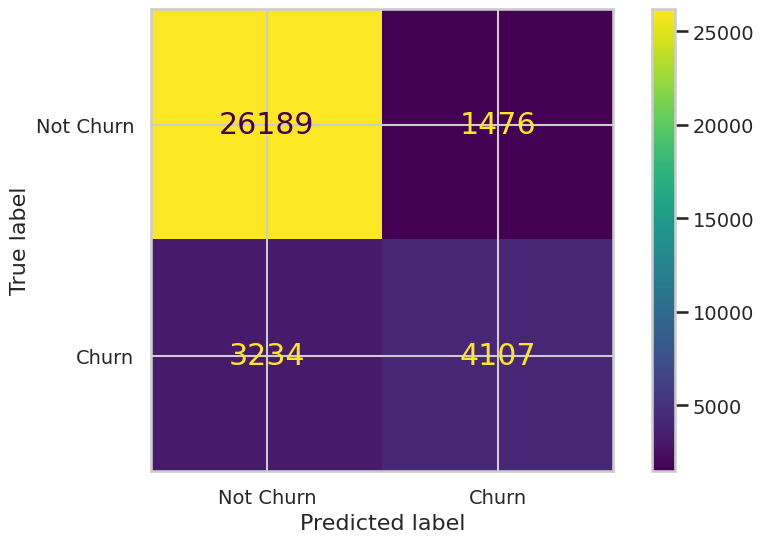

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_pipeline_optimized.fit(X_train, y_train)
predictions_xgb = xgb_pipeline_optimized.predict(X_val)
cm_xgb = confusion_matrix(y_val, predictions_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Not Churn', 'Churn'])
disp.plot()
plt.show()

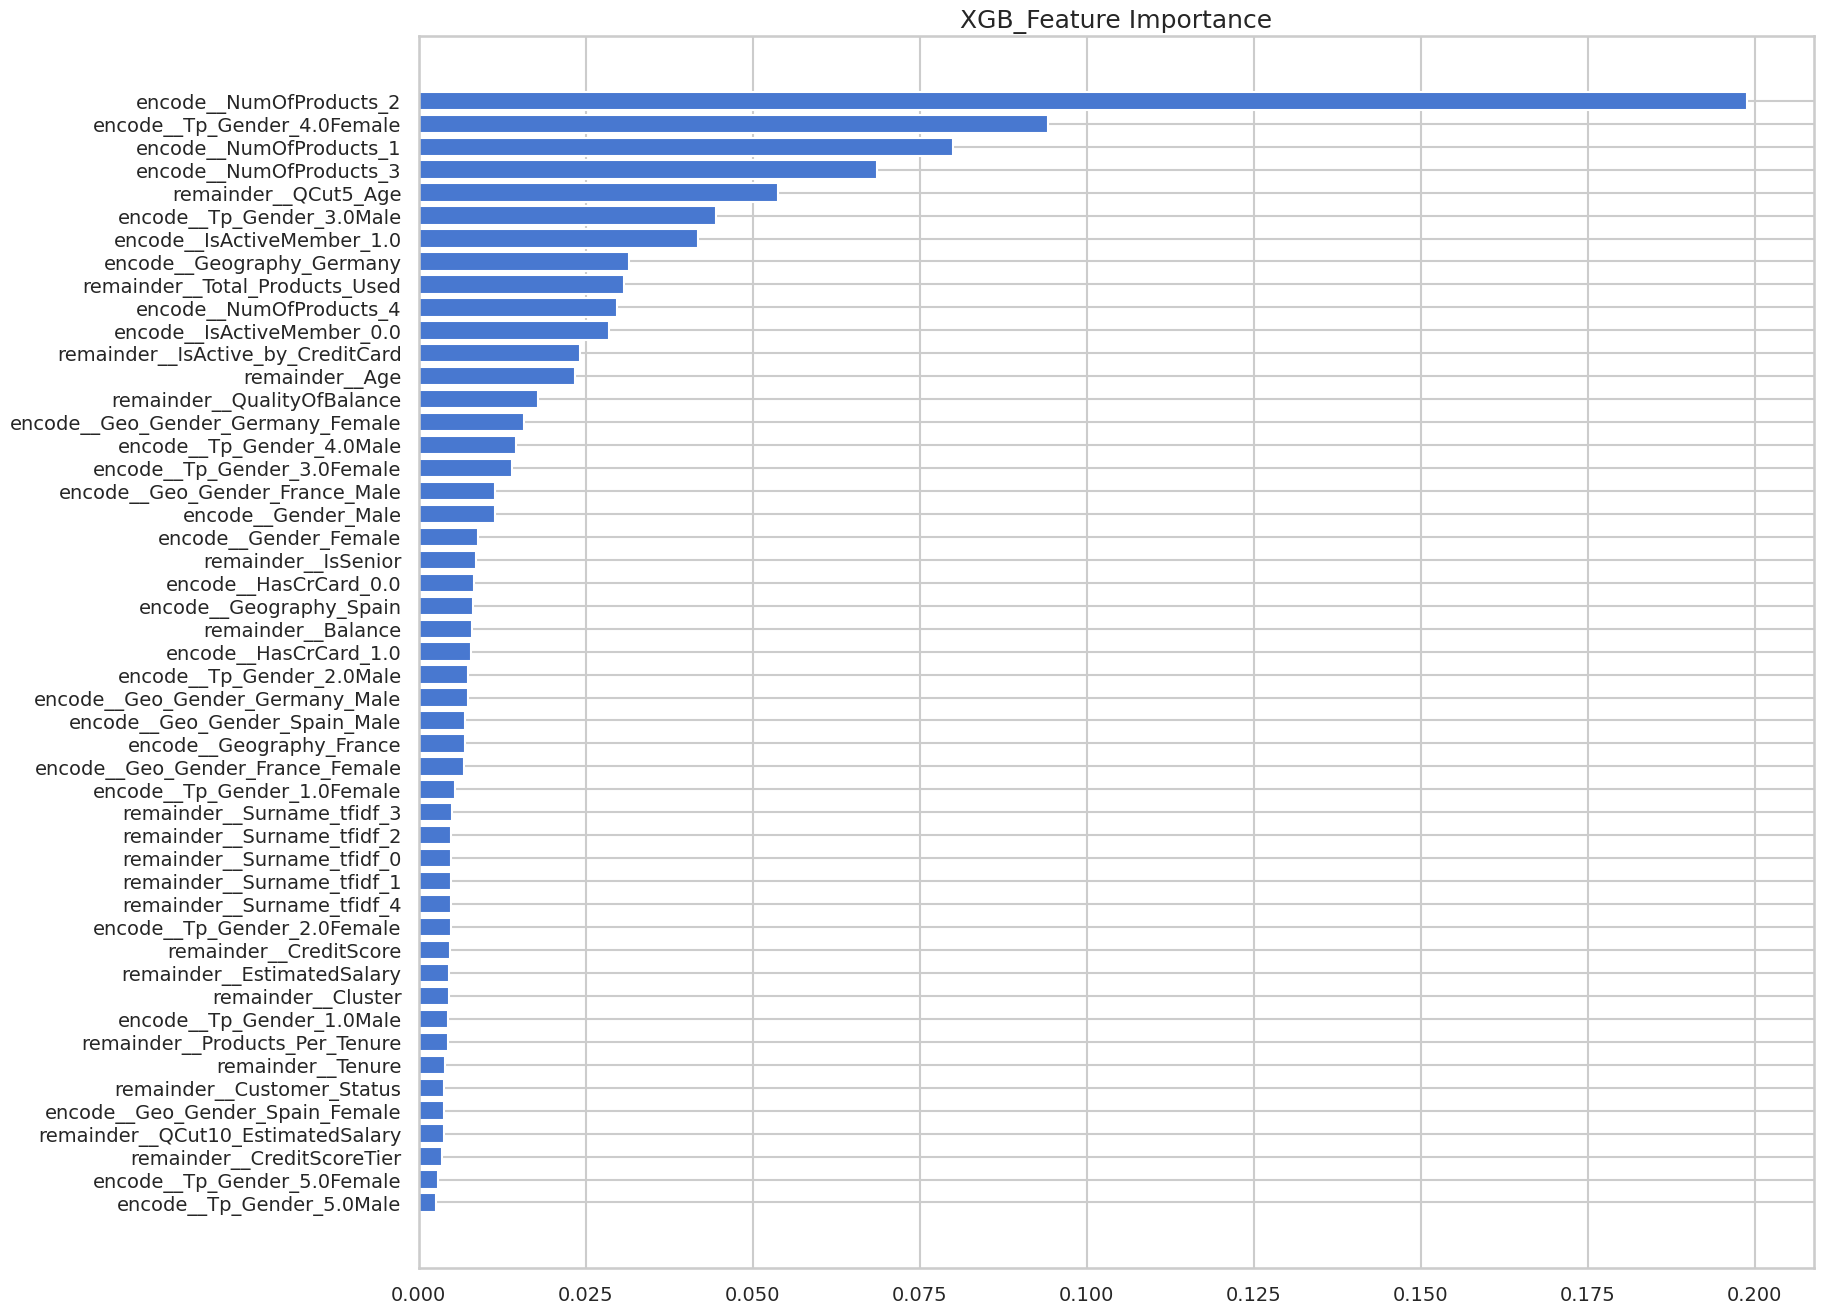

In [ ]:
xgb_feature_importance = xgb_pipeline_optimized.named_steps['xgbclassifier'].feature_importances_
train_X = modelling_pipeline.fit_transform(train.drop(['Exited'], axis=1))

sorted_idx = np.argsort(xgb_feature_importance)
fig = plt.figure(figsize=(18, 16))
plt.barh(range(len(sorted_idx)), xgb_feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train_X.columns)[sorted_idx])
plt.title('XGB_Feature Importance')
plt.show()

### lightgbm

In [ ]:
import warnings
# Suppress LightGBM warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*num_leaves.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*No further splits with positive gain.*")

import lightgbm as lgb
from lightgbm import LGBMClassifier

In [ ]:
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# def objective_lgbm(trial):
#     """Define the objective function for LGBMClassifier"""

#     params = {
#         'objective': 'binary',  # Objective for binary classification
#         'boosting_type': 'gbdt',
#         'device': 'gpu', # Use GPU for training
#         'metric': 'auc',  # Evaluation metric
#         'max_depth': trial.suggest_int('max_depth', 5, 10),
#         'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 150, 1000),
#         'subsample': trial.suggest_float('subsample', 0.1, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
#         'random_state': 42,
#     }

#     lgb_model = lgb.LGBMClassifier(**params)
#     lgb_pipeline = make_pipeline(modelling_pipeline, lgb_model)

#     cv = abs(cross_val_score(lgb_pipeline, X, y, cv=skf, scoring='roc_auc').mean())

#     return cv

# # Create an Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective_lgbm, n_trials=10)

# # Get the best parameters
# best_params_lgb = study.best_params
# print("Best Hyperparameters for LGBM:", best_params_lgb)

In [ ]:
best_params_lgb = {'max_depth': 7, 'min_child_samples': 4, 'learning_rate': 0.13268890030861658, 'n_estimators': 224, 'subsample': 0.8049917280762349, 'colsample_bytree': 0.23135818641880346, 'reg_alpha': 0.4779317899973703, 'reg_lambda': 0.6945532028647108}

In [ ]:
lgb_model_optimized = lgb.LGBMClassifier(**best_params_lgb, random_state=42)
lgb_pipeline_optimized = make_pipeline(modelling_pipeline, lgb_model_optimized)

In [ ]:
# n_splits = 10
# stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
# cv_results = []

# for fold, (train_idx, val_idx) in enumerate(stratkf.split(X, y)):
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#     lgb_pipeline_optimized.fit(X_train, y_train)
#     y_val_pred_prob = lgb_pipeline_optimized.predict_proba(X_val)[:, 1]
#     y_pred = lgb_pipeline_optimized.predict(X_val)
#     f1 = f1_score(y_val, y_pred, average='weighted')

#     # Evaluating the model
#     roc_auc = roc_auc_score(y_val, y_val_pred_prob)
#     print(f'Fold {fold + 1}, AUC-Score on Validation Set: {roc_auc}')
#     print(f'Fold {fold + 1}, F1 Score on Validation Set: {f1}')
#     print('-'*70)

#     cv_results.append(roc_auc)

# average_cv_result = sum(cv_results) / n_splits
# print(f'\nAverage AUC-SCORE across {n_splits} folds: {average_cv_result}')

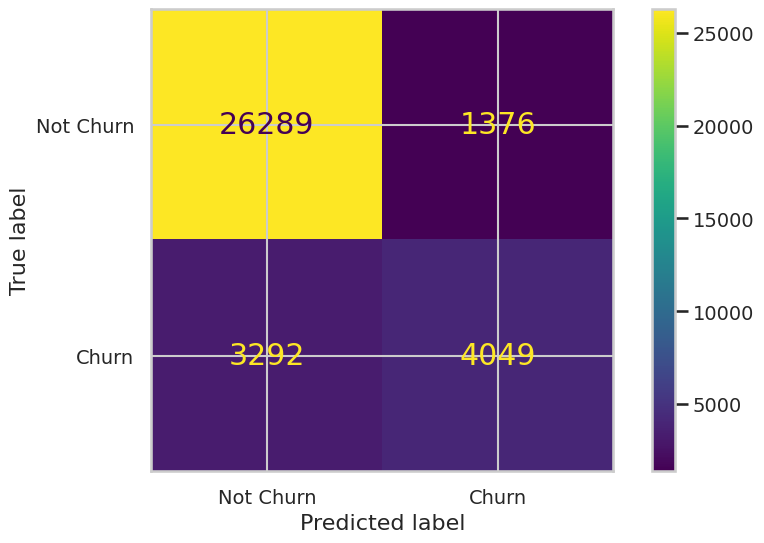

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
lgb_pipeline_optimized.fit(X_train, y_train)
predictions_lgb = lgb_pipeline_optimized.predict(X_val)
cm_lgb = confusion_matrix(y_val, predictions_lgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lgb, display_labels=['Not Churn', 'Churn'])
disp.plot()
plt.show()

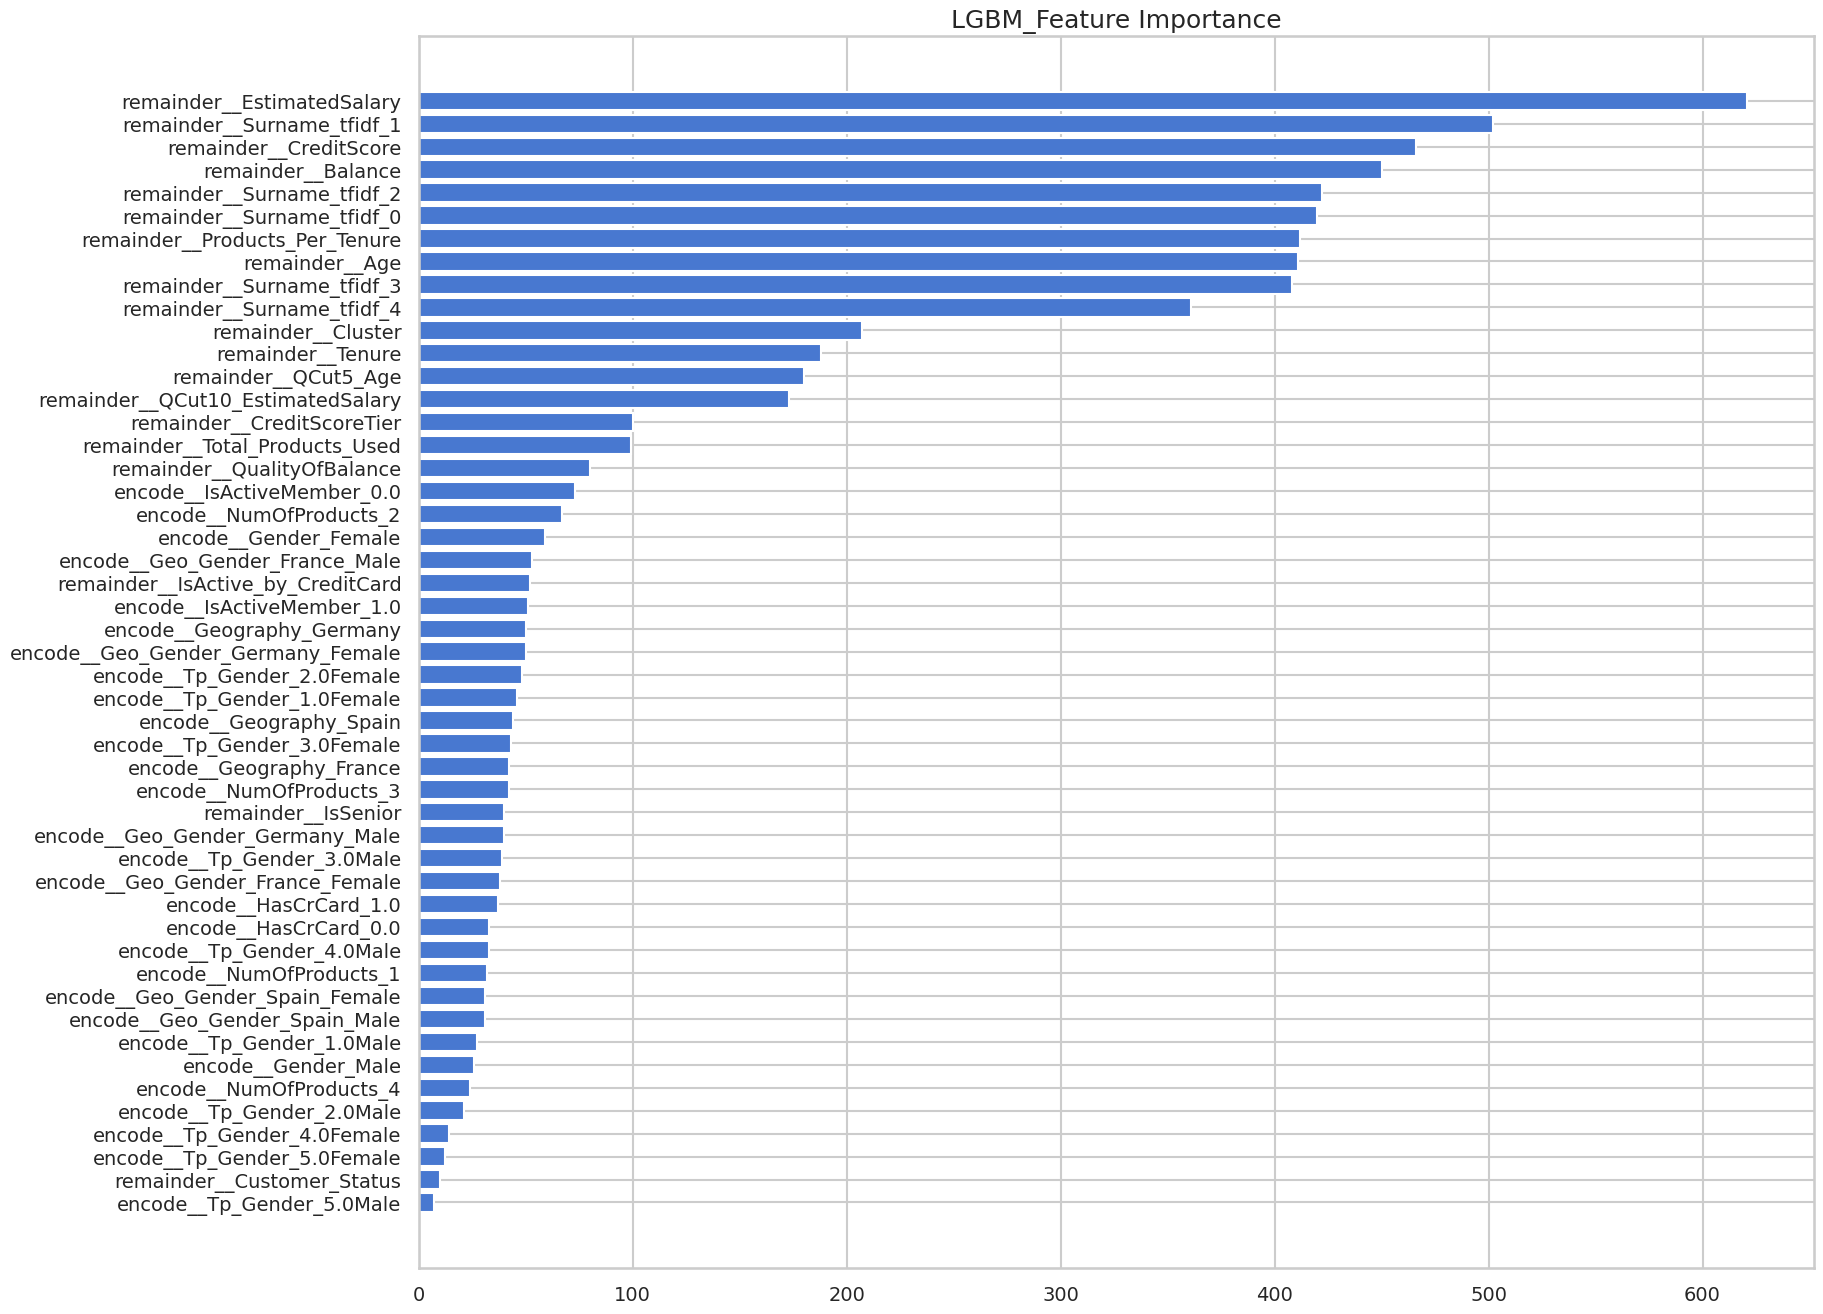

In [ ]:
lgbm_feature_importance = lgb_pipeline_optimized.named_steps['lgbmclassifier'].feature_importances_
sorted_idx = np.argsort(lgbm_feature_importance)
fig = plt.figure(figsize=(18, 16))
plt.barh(range(len(sorted_idx)), lgbm_feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train_X.columns)[sorted_idx])
plt.title('LGBM_Feature Importance')
plt.show()

### catboost

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
# Suppress FutureWarnings related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1000),
        'depth': trial.suggest_int('depth', 10, 16),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 20),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.2, log=True),
    }
    
    cb_model = CatBoostClassifier(**params, random_state=42, grow_policy='Lossguide', verbose=0)
    cb_pipeline = make_pipeline(modelling_pipeline, cb_model)
    

    cv = abs(cross_val_score(cb_pipeline, X, y, cv=skf, scoring='roc_auc').mean())
    return cv

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_params_cb = study.best_params
print("Best Hyperparameters for CatBoost:", best_params_cb)

In [ ]:
best_params_cb = {'iterations': 809, 'depth': 13, 'min_data_in_leaf': 10, 'learning_rate': 0.05064670834389193}

In [ ]:
cb_model = CatBoostClassifier(**best_params_cb, random_state=42, verbose=0)
cb_pipeline_optimized = make_pipeline(modelling_pipeline, cb_model)

In [ ]:
n_splits = 10
stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

cv_results = []

for fold, (train_idx, val_idx) in enumerate(stratkf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    cb_pipeline_optimized.fit(X_train, y_train)

    y_val_pred_prob = cb_pipeline_optimized.predict_proba(X_val)[:, 1]
    y_pred = cb_pipeline_optimized.predict(X_val)
    f1 = f1_score(y_val, y_pred, average='weighted')

    # Evaluating the model
    logloss = log_loss(y_val, y_val_pred_prob)
    roc_auc = roc_auc_score(y_val, y_val_pred_prob)
    print(f'Fold {fold + 1}, AUC-Score on Validation Set: {roc_auc}')
    print(f'Fold {fold + 1}, F1 Score on Validation Set: {f1}')
    print(f'Fold {fold + 1}, Log Loss Score on Validation Set: {logloss}')
    print('-'*70)

    cv_results.append(logloss)

average_cv_result = sum(cv_results) / n_splits
print(f'\nAverage Logarithmic Loss across {n_splits} folds: {average_cv_result}')


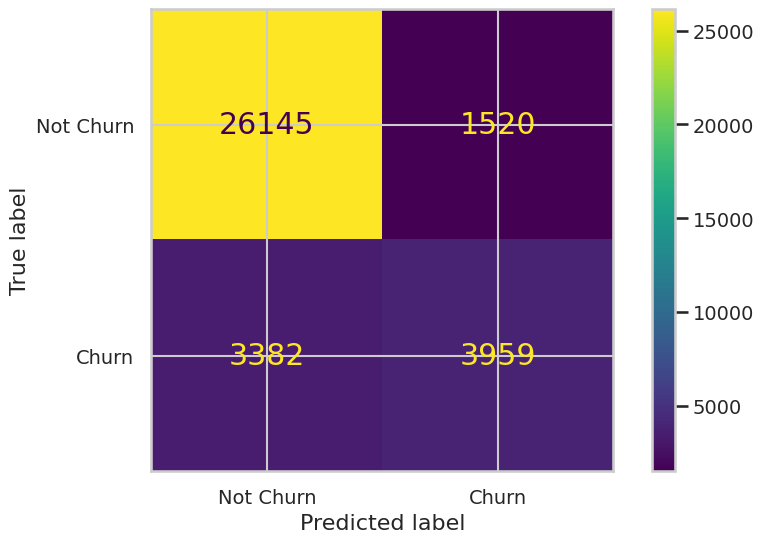

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

cb_pipeline_optimized.fit(X = X_train,
                y = y_train)

predictions_cb = cb_pipeline_optimized.predict(X_val)

cm_cb = confusion_matrix(y_val, predictions_cb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_cb, display_labels=['Not Churn', 'Churn'])
disp.plot()
plt.show()


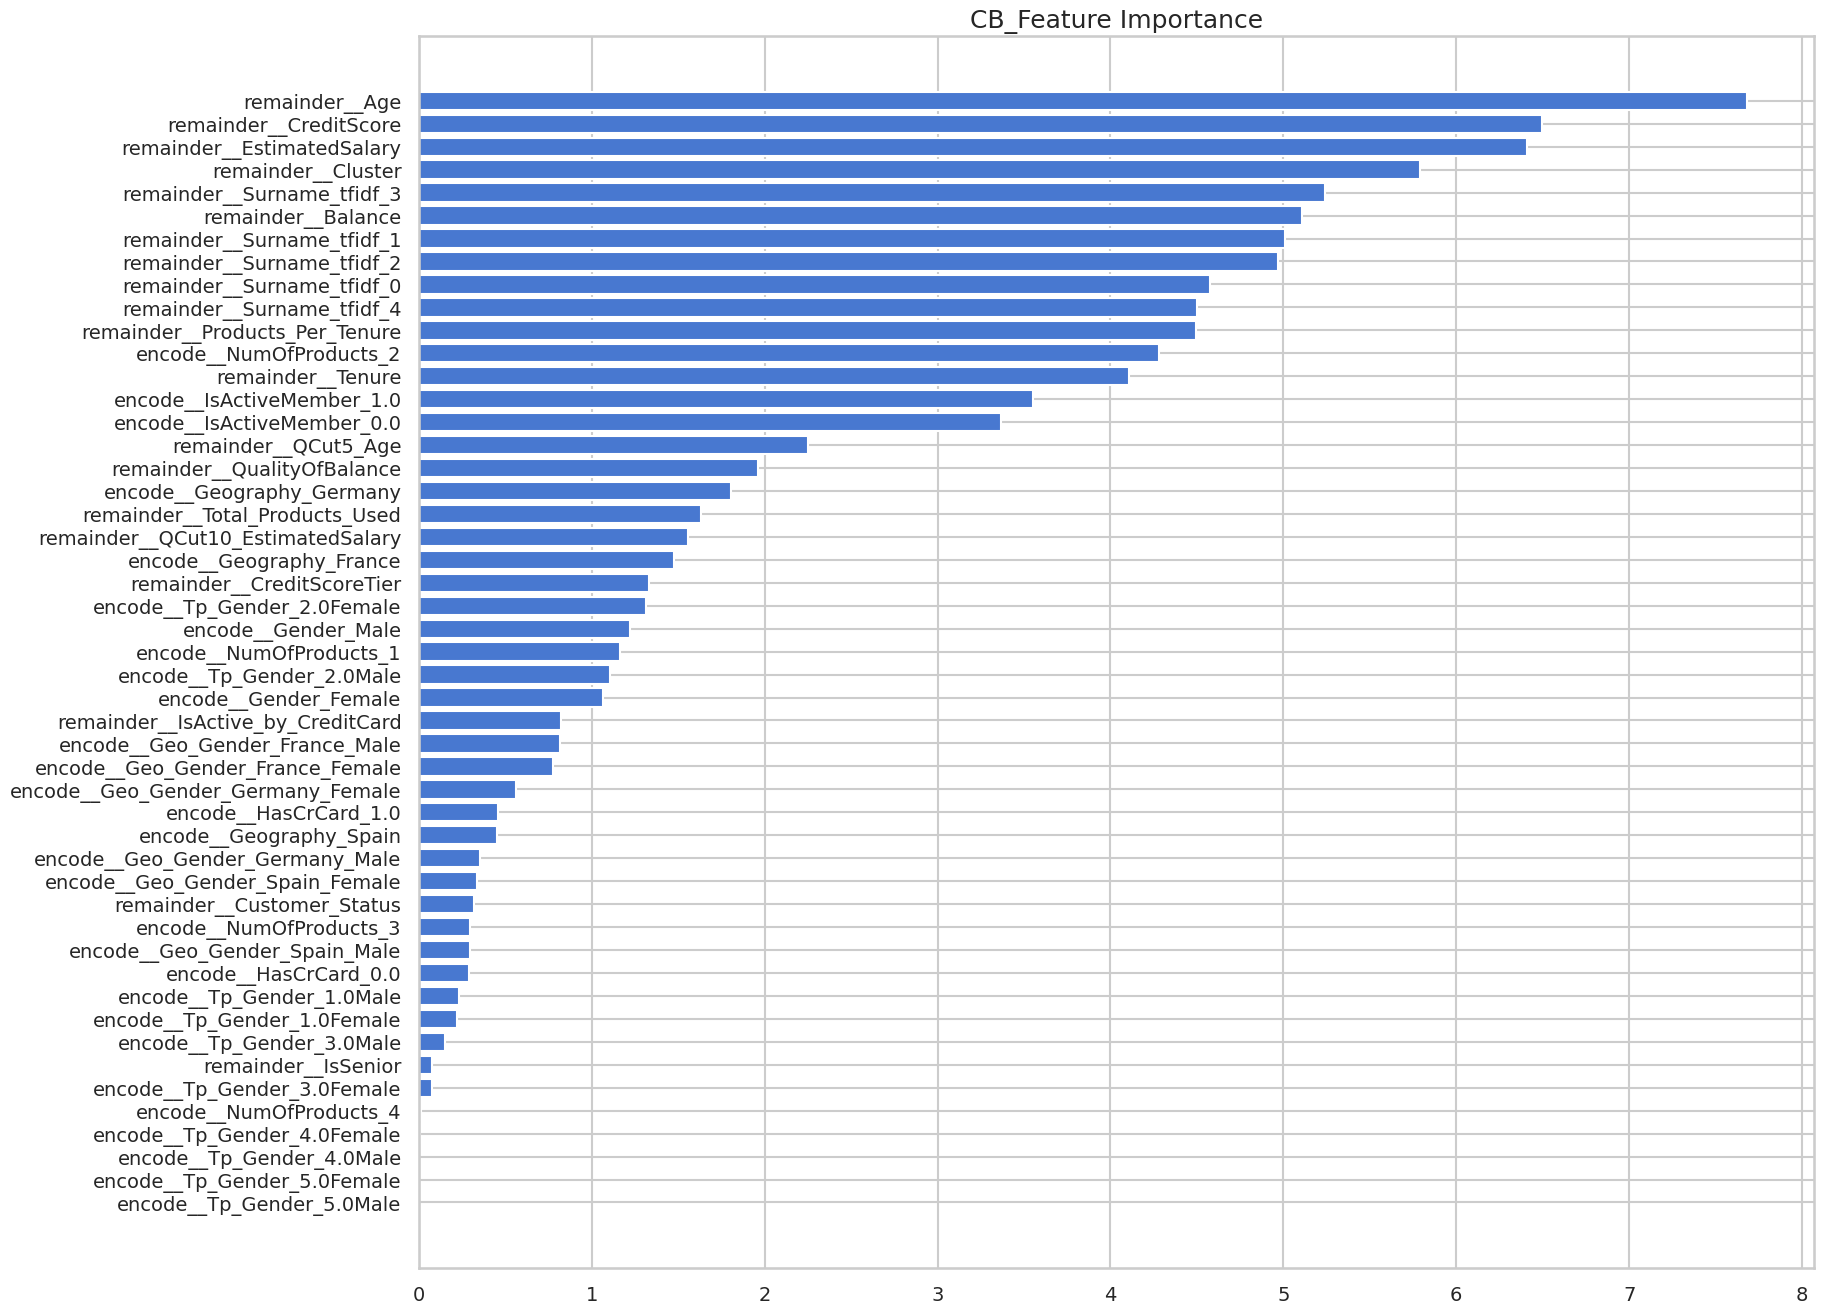

In [ ]:
cb_feature_importance = cb_pipeline_optimized.named_steps['catboostclassifier'].feature_importances_
sorted_idx = np.argsort(cb_feature_importance)
fig = plt.figure(figsize=(18, 16))
plt.barh(range(len(sorted_idx)), cb_feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train_X.columns)[sorted_idx])
plt.title('CB_Feature Importance')
plt.show()

## ensemble

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
# # Define the parameter search space
# def objective(trial):
#     weights = [
#         trial.suggest_float('weight_xgb', 0, 1),
#         trial.suggest_float('weight_lgb', 0, 1),
#         trial.suggest_float('weight_cb', 0, 1)
#     ]

#     ensemble_model = VotingClassifier(
#         estimators=[
#             ('xgb', xgb_pipeline_optimized),
#             ('lgb', lgb_pipeline_optimized),
#             ('cb', cb_pipeline_optimized)
#         ], voting='soft', weights=weights)

#     cv = abs(cross_val_score(ensemble_model, X, y, cv=skf, scoring='roc_auc').mean())

#     return cv

# # Assuming 'skf' is your StratifiedKFold object
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# # Use the 'sampler' parameter for parallelization
# study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
# study.optimize(objective, n_trials=50)

# best_weights = study.best_params
# print("Best Weights for Ensemble:", best_weights)


In [ ]:
ensemble_model = VotingClassifier(estimators=[
    ('xgb', xgb_pipeline_optimized),
    ('lgb', lgb_pipeline_optimized),
    ('cb', cb_pipeline_optimized)
], voting='soft', weights = [0.4,0.4,0.2])

ensemble_model

VotingClassifier(estimators=[('xgb',
                              Pipeline(steps=[('pipeline',
                                               Pipeline(steps=[('kmeans',
                                                                KMeansClusterer(features=['CustomerId',
                                                                                          'EstimatedSalary',
                                                                                          'Balance'],
                                                                                n_clusters=10,
                                                                                n_components=3,
                                                                                random_state=123)),
                                                               ('surname_tfid',
                                                                TFIDFTransformer(column='Surname',
                                                                                 max_features=1000,
                                                                                 n_components=5)),
                                                               ('age_binning',
                                                                VariableBinning(column_name='Age',
                                                                                n_bins=5))...
                                                                ColumnTransformer(remainder='passthrough',
                                                                                  transformers=[('encode',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse_output=False),
                                                                                                 ['Gender',
                                                                                                  'Geography',
                                                                                                  'NumOfProducts',
                                                                                                  'HasCrCard',
                                                                                                  'IsActiveMember',
                                                                                                  'Geo_Gender',
                                                                                                  'Tp_Gender'])])),
                                                               ('scale',
                                                                RobustScaler())])),
                                              ('catboostclassifier',
                                               <catboost.core.CatBoostClassifier object at 0x7a362d236bf0>)]))],
                 voting='soft', weights=[0.4, 0.4, 0.2])

In [ ]:
# # number of folds
# n_splits = 10

# # StratifiedKFold
# stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# # cross-validation results
# cv_results = []

# # stratified k-fold cross-validation
# for fold, (train_idx, val_idx) in enumerate(stratkf.split(X, y)):
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#     ensemble_model.fit(X_train, y_train)

#     # predictions on the validation set
#     y_val_pred_prob = ensemble_model.predict_proba(X_val)[:, 1]
#     y_pred = ensemble_model.predict(X_val)
        
#     f1 = f1_score(y_val, y_pred, average='weighted')

#     # Evaluating the model
#     roc_auc = roc_auc_score(y_val, y_val_pred_prob)
#     print(f'Fold {fold + 1}, AUC Score on Validation Set: {roc_auc}')
#     print(f'Fold {fold + 1}, F1 Score on Validation Set: {f1}')
#     print('-'*70)

#     # results
#     cv_results.append(roc_auc)

# # average cross-validation result
# average_cv_result = sum(cv_results) / n_splits
# print(f'\nAverage AUC-score across {n_splits} folds: {average_cv_result}')


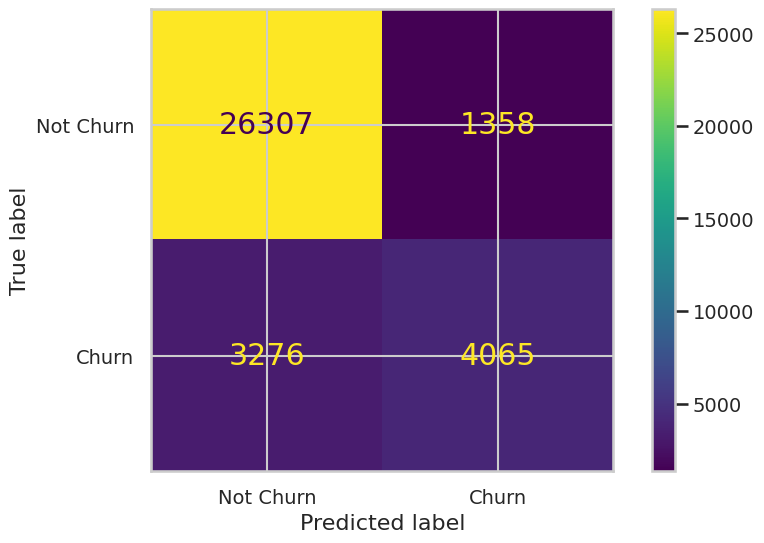

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

ensemble_model.fit(X = X_train, y = y_train)

predictions_ensemble = ensemble_model.predict(X_val)

cm_ensemble = confusion_matrix(y_val, predictions_ensemble)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble, display_labels=['Not Churn', 'Churn'])
disp.plot()
plt.show()

## Submit

In [ ]:
# Fit the ensemble final model
ensemble_model.fit(X=train.drop(['Exited'], axis=1), y=train['Exited'])

# Create submission file with probability predictions
predictions = ensemble_model.predict_proba(test)[:, 1]  # Use the probabilities of class 1

sample['Exited'] = predictions
sample.to_csv('submission.csv', index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a605a3e6-1564-47b2-94e7-842290ba7692' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>